In [21]:
import numpy as np
from queue import PriorityQueue
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt

# matrice de similarité
sim_mat = np.array([[10, 6, 0, 0, 0, 0, 0, 0, 0],
                    [6, 10, 0, 0, 0, 0, 0, 0, 0],
                    [0, 0, 10, 5, 3, 3, 1, 1, 0],
                    [0, 0, 5, 10, 1, 2, 1, 1, 0],
                    [0, 0, 3, 1, 10, 4, 1, 2, 0],
                    [0, 0, 3, 2, 4, 10, 1, 4, 0],
                    [0, 0, 1, 1, 1, 1, 10, 1, 0],
                    [0, 0, 1, 1, 2, 4, 1, 10, 0],
                    [0, 0, 0, 0, 0, 0, 0, 0, 10]])

# génération du tableau de file de priorité sans les valeurs de la diagonale
def generate_priority_queue(sim_mat):
    N = sim_mat.shape[0]
    P = []
    for i in range(N):
        P.append(PriorityQueue())
    for i in range(N):
        for j in range(N):
            if i != j:
                P[i].put((-sim_mat[i][j], j))
    return P


In [22]:
# implémentation de l'algorithme de clustering hiérarchique agglomératif
def clustering_hierarchique_agglomeratif(sim_mat):
    # Taille de la matrice de similarité
    N = sim_mat.shape[0]

    # initialisation de la liste des classes actives
    I = [1 for i in range(N)]

    # initialisation du dendrogramme comme un ndarray de taille N-1
    dendrogramme = [[0, 0] for i in range(N - 1)]

    # initialisation du tableau de file de priorité
    P = generate_priority_queue(sim_mat)
    temp_queue = PriorityQueue()
    
    # pour chaque itération k ∈ {1, . . . , N − 1} faire
    for k in range(N - 1):
        # a = argmax P[i].MAX.sim ; avec i ∈ {1, . . . , N} et I[i] = 1 ;
        a = 0
        max_sim = 1
        for i in range(N):  # on cherche la classe i la plus proche de la classe a
            if I[i] == 1 and P[i].queue[0][0] < max_sim:  # si la classe i est active et si la classe i est plus proche de la classe a que la classe a ne l'est d'elle-même
                max_sim = P[i].queue[0][0]
                a = i

        # b = P[a].MAX.index ;
        b = P[a].queue[0][1]
        
        dendrogramme[k][0] = a
        dendrogramme[k][1] = b
        
        # I[b] = 0 ;
        I[b] = 0

        # supprimer S[a][b] de P[a] ;
        P[a].get()

        for i in range(N):

            if I[i] == 1 and i != a:
                # supprimer S[i][a] de P[i] ;
                for j in range(P[i].qsize()):
                    if P[i].queue[0][1] != a and P[i].queue[0][1] != b:
                        temp_queue.put(P[i].queue[0])
                    P[i].get()
                # remettre les valeurs dans la file de priorité
                for j in range(temp_queue.qsize()):
                    P[i].put(temp_queue.queue[0])
                    temp_queue.get()

                # supprimer S[a][i] de P[a] ;
                for j in range(P[a].qsize()):
                    if P[a].queue[0][1] != i:
                        temp_queue.put(P[a].queue[0])
                    P[a].get()
                for j in range(temp_queue.qsize()):
                    P[a].put(temp_queue.queue[0])
                    temp_queue.get()

                # S[i][a] ← max{S[i][a], S[i][b]} ; # Méthode du lien unique
                sia = max(sim_mat[i][a], sim_mat[i][b])

                # S[a][i] ← max{S[i][a], S[i][b]} ;
                sai = max(sim_mat[i][a], sim_mat[i][b])

                # insérer (avec tri) S[i][a] dans P[i] et S[a][i] dans P[a] ;
                P[i].put((-sia, a))
                P[a].put((-sai, i))

    return dendrogramme

In [23]:
# test de l'algorithme de clustering hiérarchique agglomératif
dendrogramme = clustering_hierarchique_agglomeratif(sim_mat)
print(dendrogramme)

[[0, 1], [2, 3], [4, 5], [4, 7], [2, 4], [2, 6], [0, 2], [0, 8]]


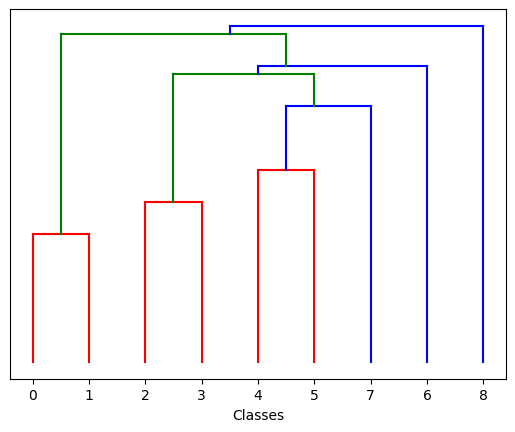

In [24]:
#                                                   #
#           Fonction d'affichage faite par          #
#                   Romain Bossy                    #
#                                                   #

N = len(sim_mat)

# Dessine la fusion de deux ensemble
def fusion(oxa, oxb, s, c, oya=10, oyb=10):
    xa = [oxa, oxa]
    xb = [oxb, oxb]

    ya = [oya, s]
    yb = [oyb, s]

    xl = [oxa, oxb]
    yl = [s, s]

    plt.plot(xa, ya, color=c)
    plt.plot(xb, yb, color=c)
    plt.plot(xl, yl, color=c)


# Dessine le dendogramme à partir de sa liste des fusions
def affichage_dendrogramme(L):
    nums = [i for i in range(N)]
    ens = []
    sims = []
    operations = []

    # Constructions de la liste des opérations de dessin que à faire
    for f in L:
        if f[0] in nums and f[1] in nums:
            ens.append(f.copy())
            sims.append(sim_mat[f[0], f[1]])
            operations.append(("Ajout ensemble", f.copy()))
        elif f[1] in nums and not f[0] in nums:
            i = 0
            while not f[0] in ens[i]:
                i += 1
    
            nouvelle_sim = min(sims[i] - 0.25, sim_mat[f[0], f[1]])
            operations.append(("Ajout élément", ens[i].copy(), f[1], sims[i], nouvelle_sim))
            sims[i] = nouvelle_sim
            ens[i].append(f[1])
        elif f[0] in nums and not f[1] in nums:
            i = 0
            while not f[1] in ens[i]:
                i += 1
    
            nouvelle_sim = min(sims[i] - 0.25, sim_mat[f[0], f[1]])
            operations.append(("Ajout élément", ens[i].copy(), f[0], sims[i], nouvelle_sim))
            sims[i] = nouvelle_sim
            ens[i].append(f[0])
        else:
            i = 0
            while not f[0] in ens[i]:
                i += 1
    
            j = 0
            while not f[1] in ens[j]:
                j += 1
            
            nouvelle_sim = min(sims[i], sims[j]) - 1
            gauche = (max(ens[i]) + min(ens[i])) / 2
            droite = (max(ens[j]) + min(ens[j])) / 2
            operations.append(("Fusion", ens[i].copy(), ens[j].copy(), sims[i], sims[j], nouvelle_sim, gauche, droite))
            sims[i] = nouvelle_sim
            ens[i].extend(ens[j])
            ens.pop(j)
            sims.pop(j)
            
        if f[0] in nums:
            nums.remove(f[0])
        if f[1] in nums:
            nums.remove(f[1])
    
    positions_x = {}
    for i in range(len(ens[0])):
        positions_x[ens[0][i]] = i 

    # Dessin du dendogramme à partir des opérations de dessin déterminées plus tôt
    for op in operations:
        type = op[0]
        if type == "Ajout ensemble":
            e = op[1]
            fusion(positions_x[e[0]], positions_x[e[1]], sim_mat[e[0], e[1]], 'red')
        elif type == "Ajout élément":
            pos = []
            for i in range(len(op[1])):
                pos.append(positions_x[op[1][i]])
            
            a = sum(pos) / float(len(pos))
            b = op[2]
            fusion(a, positions_x[b], op[4], 'blue', oya=op[3])
        elif type == "Fusion":
            pos = []
            for i in range(len(op[1])):
                pos.append(positions_x[op[1][i]])
            a = sum(pos) / float(len(pos))

            pos = []
            for i in range(len(op[2])):
                pos.append(positions_x[op[2][i]])
            b = sum(pos) / float(len(pos))
            
            fusion(a, b, op[5], 'green', oya=op[3], oyb=op[4])

    # Les labels des classes
    labels = []
    for i in positions_x.keys():
        labels.insert(positions_x[i], str(i))
    
    plt.xticks(list(positions_x.values()), labels)
        
    # On supprime l'axe des y et on l'inverse
    plt.gca().axes.get_yaxis().set_visible(False)
    plt.gca().invert_yaxis()
    plt.xlabel("Classes")
    plt.show()

affichage_dendrogramme(dendrogramme)

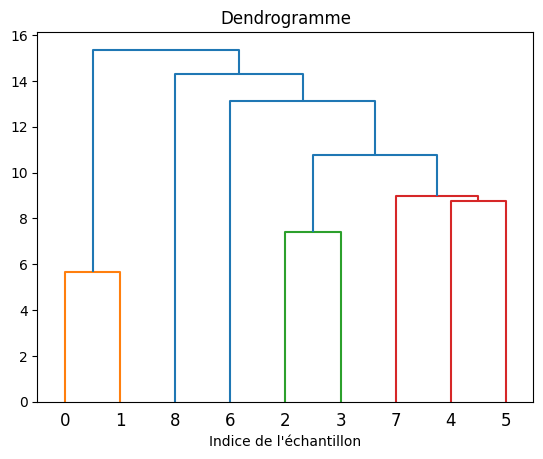

In [25]:
# maintenanat on va utiliser la fonction de scipy pour comparer les résultats
linkage_matrix = linkage(sim_mat, 'single') # Elle est composé de N-1 lignes et 4 colonnes (i, j, d, n) avec i et j les indices des clusters fusionnés, d la distance entre les clusters et n le nombre d'éléments dans le cluster
dendrogram(linkage_matrix, orientation='top')
plt.title('Dendrogramme')
plt.xlabel('Indice de l\'échantillon')
plt.show()

# Conclusion :
# On remarque que les deux dendrogrammes sont identiques, ce qui signifie que notre implémentation de l'algorithme de clustering hiérarchique agglomératif est correcte.